# Extending to two switch points

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

In [2]:
figsize(12.5, 3.5)
count_data = np.loadtxt('txtdata.csv')
n_count_data = len(count_data)

$$
\lambda = \begin{cases}
\lambda_{1}\text{ if } t \lt \tau_{1}\\
\lambda_{2}\text{ if } \tau_{1} \leq t \lt \tau_{2}\\
\lambda_{3}\text{ if } t \geq \tau_{2}
\end{cases}
$$

Where:

$$
\lambda_{1} \sim \text{Exp}(\alpha)\\
\lambda_{2} \sim \text{Exp}(\alpha)\\
\lambda_{3} \sim \text{Exp}(\alpha)
$$

and:

$$
\tau_{1} \sim \text{DiscreteUniform}(1,69)\\
\tau_{2} \sim \text{DiscreteUniform}(\tau_{1}, 70)
$$

In [3]:
import pymc as pm
# Recall that count data is the variable
# that holds our text counts

alpha = 1.0 / count_data.mean()

In [4]:
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)

In [5]:
tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data-1)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)

In [6]:
@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2, 
           lambda_1=lambda_1, lambda_2=lambda_2,
           lambda_3=lambda_3):
    out = np.zeros(n_count_data) # number of data points
    out[:tau_1] = lambda_1 # lambda before tau is lambda_1
    out[tau_1:tau_2] = lambda_2
    out[tau_2:] = lambda_3 # lambda after (and including) tau is lambda_2
    return out

In [7]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

In [8]:
model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1, tau_2])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

c:\users\user\anaconda3\envs\pymc\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 11.2 sec

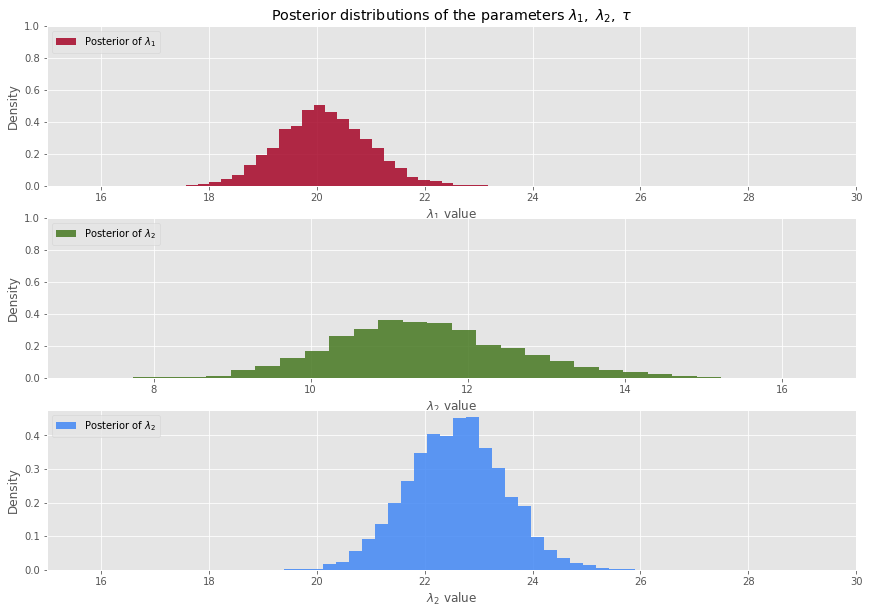

In [9]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
lambda_3_samples = mcmc.trace('lambda_3')[:]
tau_1_samples = mcmc.trace('tau_1')[:]
tau_2_samples = mcmc.trace('tau_2')[:]

figsize(14.5, 10)
# histogram of the samples

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=.85, 
        label='Posterior of $\lambda_1$', color='#A60628', normed=True);
plt.legend(loc = "upper left");
plt.title(r"""Posterior distributions of the parameters\
 $\lambda_1, \;\lambda_2, \; \tau$""");
plt.xlim([15, 30]);
plt.xlabel('$\lambda_1$ value');
plt.ylabel('Density');

ax = plt.subplot(312);
ax.set_autoscaley_on(False);
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=.85,
        label='Posterior of $\lambda_2$', color='#467821', normed=True,
        rwidth=.2);
plt.legend(loc='upper left');
# plt.xlim([15, 30]);
plt.xlabel('$\lambda_2$ value');
plt.ylabel('Density');

plt.subplot(313);
ax.set_autoscaley_on(False);
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=.85,
        label='Posterior of $\lambda_2$', color='#4287f5', normed=True,
        rwidth=.2);
plt.legend(loc='upper left');
plt.xlim([15, 30]);
plt.xlabel('$\lambda_2$ value');
plt.ylabel('Density');